## Семинар 10: "Генерация текстов"

In [2]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from tqdm import tqdm
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [3]:
! head -n 2 ../author-quote.txt

head: cannot open '../author-quote.txt' for reading: No such file or directory


In [4]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]

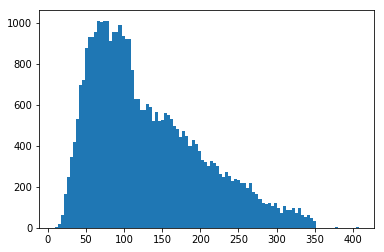

In [5]:
plt.hist(list(map(lambda x: len(x), lines)), bins=100);

In [6]:
line = lines[0]
line

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

In [7]:
lines = list(filter(lambda x: len(x) <= 50, lines))

In [8]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(all_characters)+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return np.array([self.char_to_id[x] for x in line])
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [9]:
vocab = Vocabulary(lines)

In [10]:
vocab.encode(lines[0])

array([26, 34, 34, 43, 17, 13, 37,  4, 34, 13, 64, 58, 29, 31, 34,  4, 17,
       13, 24, 29, 29, 36, 13, 29, 65, 48, 34, 13, 63, 29, 71, 13, 55, 34,
       24, 13, 24, 29, 13, 66, 65, 29, 31, 13, 24, 41, 34, 14,  1])

In [11]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [12]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        input = self.vocab.encode(['<go>'] + list(self.sentences[idx]))
        output = self.vocab.encode(list(self.sentences[idx])+['<eos>'])
        return input, output

In [13]:
dataset = Quotes(lines, vocab)

In [14]:
dataloader = DataLoader(dataset, shuffle=True)

### Часть 2: определение модели

In [30]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size).cuda()
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=True).cuda()
        self.classifier = nn.Linear(hidden_size, vocabulary_size).cuda()
        self.softmax = nn.Softmax().cuda()
        self.indexes = np.array([i for i in range(vocabulary_size)])
    
    def forward(self, input):
        embedding = self.embedding(input)
        h = Variable(torch.Tensor(self.layers, 1, self.hidden_size).normal_(), requires_grad=False).cuda()
        output, _ = self.generator(embedding, (h))
        classes = self.classifier(output[0])
        return classes
    
    def generate(self, vocab, max_len=100):
        h = Variable(torch.Tensor(self.layers, 1, self.hidden_size).normal_(), requires_grad=False).cuda()
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True).cuda()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            probs = self.softmax(classes)
            new_token_id = np.random.choice(self.indexes, 1, p=probs.data[0].cpu().numpy())[0]
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [31]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

### Часть 3: обучение модели

In [49]:
optimizer = torch.optim.Adam(oracle.parameters(), lr=0.0001)

In [33]:
criterion = nn.CrossEntropyLoss().cuda()

In [34]:
losses = []

In [50]:
# несколько раз останавливал, менял lr и продолжнал обучаться, 
# так что количество эпох лучше оценить по графику loss
for epoch in tqdm(range(1000)):
    for i, (batch, target) in enumerate(dataloader):
        batch = Variable(batch).cuda()
        target = Variable(target, requires_grad=False).cuda()[0]
        prediction = oracle(batch)
        loss = criterion(prediction, target)
        loss.backward()
        if i % 32 == 0:
            optimizer.step()
            oracle.zero_grad()
            losses.append(loss.data[0])
            print(loss.data[0], oracle.generate(vocab))


  0%|          | 0/1000 [00:00<?, ?it/s]

0.7175258994102478 I didn't hen the sitalit.<eos>
0.9409626126289368 I always into with my speate.<eos>
1.259419322013855 I never a play some discippined, was age;.<eos>
0.9569292664527893 Life you like a good a pask.<eos>
1.3585798740386963 There end fact a dreams my life.<eos>
1.371543526649475 I want to be believe in great doing only can.<eos>
0.878473162651062 We life every lock height writen I am.<eos>



Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/sphere_7/anaconda3/envs/analytics/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sphere_7/anaconda3/envs/analytics/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sphere_7/anaconda3/envs/analytics/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



1.2005999088287354 I want to be like to angening.<eos>
0.6866831183433533 Lxy my mean, I could hi'jat.<eos>
0.7380878329277039 True -nen is hour big a gentleman.<eos>
0.9845762848854065 I want to be a baker happily.<eos>
1.1109484434127808 Men we're just and no brade only in somedto<eos>
1.3250210285186768 Real chose will the behon hearing distance.<eos>
0.9000768661499023 Silence is the mother will full lonelftore in relight.<eos>
1.006190299987793 Jyper friend in instithel seegly happy.<eos>
1.193938970565796 I've always can't show him it's only There is.<eos>
0.9629437327384949 I'm not everyone inter.<eos>
1.2832585573196411 Nothing is a cow.<eos>
1.368874192237854 There are no day is a vity bad.<eos>
0.9213492274284363 I'm freedom great one very businect.<eos>
1.365514874458313 Contradiality is the road that is remoone without a.<eos>
1.0469335317611694 I really home matter right of a people only another livering lliver.<eos>
1.0092439651489258 I want to self dance on my fedrated.<

  0%|          | 1/1000 [00:40<11:17:48, 40.71s/it]

1.3895034790039062 Being littlers not not because I?<eos>
0.8489827513694763 Artise of my paronice us areing lawry.<eos>
1.0717089176177979 I hardly creative for a Deans when I gues it.<eos>
1.105220079421997 I didn't necest, as an aventy in drime of marrish.<eos>
1.3734493255615234 I believe it late things over 'dures.<eos>
1.1751562356948853 Remanguesing is always of will on life.<eos>
1.2947022914886475 We gettune, nicer and at noughacp.<eos>
1.7519100904464722 A come of cometimes me who kill-words.<eos>
1.0925406217575073 Bewarsdine tip thing to be retend.<eos>
1.0344432592391968 I'm always never hergiem. I am not a bad faith.<eos>
0.9205070734024048 Hell is my vactured of much of heragise.<eos>
1.5787630081176758 Choorake me,, so but your 3Ttynneters.<eos>
1.7255842685699463 There, that is nothing of often a less thing; it's nothing.<eos>
0.7427793145179749 We're bomes the half-prish am not a nound juer.<eos>
1.302376389503479 I do power ain't ed to be up etrage.<eos>
1.0447456836

  0%|          | 2/1000 [01:21<11:17:08, 40.71s/it]

0.8525152206420898 I was dangerouge, antimoning. I did-time.<eos>
1.0343254804611206 The devilly is grand enough intracks.<eos>
1.2212707996368408 I think acchombpord over loselys want.<eos>
0.9722485542297363 An actor feep the angry as really, sya in best.<eos>
1.1936694383621216 I tlatever by the aroad are true it.<eos>
1.0086110830307007 Plowem no learne for we'r work if well revord.<eos>
0.8317626714706421 A punger Iarant to be when I'm boung.<eos>
1.0110936164855957 Ligcing as the things home before fate without me.<eos>
0.831632673740387 No one is the shall you dream competitudion.<eos>
1.0938787460327148 Where recush is tonage happy, grief and if music.<eos>
1.05677330493927 Sometimes better the servication.<eos>
1.1635626554489136 When it lack a girl wonders necessians, standing.<eos>
1.3116211891174316 They nuth for your momerataclity with priviors.<eos>
0.9215933084487915 I want sure every the samide.<eos>
1.8033746480941772 Doglyfigto Ced to shorked as a lipsy as priviling.<

  0%|          | 3/1000 [01:59<11:04:36, 40.00s/it]

1.3789644241333008 The future into time recente a loves fortune.<eos>
0.7719327211380005 I'm not a music supressent Canany.<eos>
0.8287708163261414 I do might good if you are about the race.<eos>
1.0267680883407593 In about my faolied without a childkolating.<eos>
1.0482401847839355 The pading like to worse things out and a big thing limit.<eos>
1.2175023555755615 I always had dreamer dedy, makes, the rotable.<eos>
1.090293526649475 I'm a pleasure mankind. It ambiors life.<eos>
1.0198967456817627 Suther because I sperents.<eos>
1.5057251453399658 The dimanity if I, suckled 112 parisitibes my wisef.<eos>
1.1547865867614746 My first forgies. Wisely our self.<eos>
1.1055117845535278 A prone every map, a sool, and theater.<eos>
0.8331737518310547 All how singer restics.<eos>
1.0659708976745605 That is sage buld in alone admite.<eos>
1.3714394569396973 I'm always know I'm reason, just institure.<eos>
1.0861084461212158 I like to be want.<eos>
1.2282445430755615 I love here in my Wasrion.<eo

  0%|          | 4/1000 [02:39<11:00:48, 39.81s/it]

0.8578162789344788 Beautics are parst plapers on the soul.<eos>
0.9747132658958435 Sex is advarant of the very an illo! A prighess.<eos>
0.914093554019928 Much lives is produate thing to live.<eos>
1.3001179695129395 Must don't need blesshine brewed.<eos>
1.0115424394607544 Chality is filledgied - command.<eos>
1.0564043521881104 God has thrue wrised your great progress.<eos>
0.9757373929023743 To star, Never more choose of able.<eos>
1.3746005296707153 I like timely a movashionics before you're an eas.<eos>
1.4294201135635376 My humiliye of talk as a man, of lowl.<eos>
1.134926199913025 I was take more time sides in England.<eos>
1.1151355504989624 Counser is a pennicawed people in pearned grow.<eos>
0.9887496829032898 I am just have nave probscation.<eos>
1.4607816934585571 It's always talk theater old.<eos>
1.0761864185333252 Woman is subergees-thing.<eos>
0.957739531993866 You can't tenglen myself paoks, any to advernent.<eos>
0.9796977639198303 Making succee shoulss heroess.<eos>


  0%|          | 5/1000 [03:16<10:51:01, 39.26s/it]

0.9452328085899353 Men of compances conside is endependa to don.<eos>
1.0635603666305542 Catures, and was a past basebalow.<eos>
1.2342487573623657 Bain is God's confunent lavy.<eos>
0.7296554446220398 If you're imous the silver you work.<eos>
1.1465649604797363 A cament much erreation that divitary is 'sy.<eos>
1.4845192432403564 I saw an angglity, man kids and harne, 1970s!<eos>
1.1999849081039429 We music, the Maties an actor, I was an an.<eos>
1.1527655124664307 I am a cluston of like aloness.<eos>
1.353728175163269 My man to be ones and the stadiences.<eos>
1.0735130310058594 In this is the singence of the time.<eos>
0.9780924916267395 I love aflegabill. I alonm and you're faith.<eos>
0.973510205745697 Art man's femole, desire dead to Stinal things workes.<eos>
1.4096866846084595 A prudent helps design solity is chelack demantite and they write; make mastoned.<eos>
1.3165702819824219 If you can the whistocies not heaven, who kinds.<eos>
1.2796803712844849 I'm about them I sweet I 

  1%|          | 6/1000 [03:57<10:55:10, 39.55s/it]

0.9196068048477173 Apte is the best light of all far me.<eos>
0.734875500202179 I like to be a bord.<eos>
1.530004858970642 A contrancica is the speced thing the raad.<eos>
1.5478994846343994 I'm guy the morivity interestage.<eos>
1.2173023223876953 I am skecriging for a gentle.<eos>
0.9644557237625122 Fear is the glavirase, our going ask a bitized places.<eos>
1.2288976907730103 I demitter to somestene passers to get up.<eos>
1.447548508644104 To possible is deplational.<eos>
1.1596064567565918 Women are the dead to New, juther to control nortardam.<eos>
1.4384777545928955 Everybody's aaps any really as a very allied.<eos>
1.314396619796753 I lessed stand into life.<eos>
1.1777012348175049 Democracy is weatryoffle and transe for tiperde.<eos>
1.03792405128479 Everything, simple sense as be done in 2ghame us.<eos>
0.9783704280853271 I don't like to finipronis out face.<eos>
1.024497389793396 I think endure is tocar kid.<eos>
0.935064435005188 None gettine durd to get even. Desel heroes

  1%|          | 7/1000 [04:30<10:39:13, 38.62s/it]

1.073634386062622 I don't really music baked, no moves way.<eos>
1.2209023237228394 I did and happily speak Stive up in the easy.<eos>
1.0531028509140015 I am untromer harn.<eos>
1.4019314050674438 Unottence is idealous impossible being never honest.<eos>
0.8487470746040344 I'm not a burined every age always may.<eos>
0.7700695991516113 Compissommons miss blees doesn't fashion.<eos>
0.9479171633720398 There's silence loser, you will to actor.<eos>
1.0058002471923828 Cristers the forge things on a groes humou.<eos>
1.68065345287323 The only singers you do.<eos>
1.1652737855911255 Grief is a was unfiniter of friends.<eos>
1.0301554203033447 Always embody just for Gute.<eos>
0.953685998916626 An ouf me people us and JoTet ownse.<eos>
1.1905065774917603 Soevens without for a proverampean.<eos>
1.0987855195999146 Respance comes the only rainced to do finishes.<eos>
1.1706199645996094 Look is borny words.<eos>
1.4479690790176392 I tireachs our atho anyone is forgiven tell.<eos>
1.22711420059

  1%|          | 8/1000 [05:04<10:30:01, 38.11s/it]

1.1195902824401855 I've been - help 2-time is help I know.<eos>
1.0644280910491943 I'm succeresacisation.<eos>
1.2810373306274414 Jaugh life is the spandivic. I wouldn't silfivines I'm an actor.<eos>
0.9703336954116821 I dreams afraid of my heart.<eos>
0.8593447804450989 A sick is music in all chains are.<eos>
0.9109792113304138 He is new efforest, unges to past.<eos>
1.3508020639419556 I do not always optimints here. The worst does orne than a wewk.<eos>
1.1910371780395508 I wound seat my force.<eos>
1.1294294595718384 I was ed gentle nove and marrietion as Isels.<eos>
1.1665494441986084 Language is the cheallenter.<eos>
0.8756803870201111 No have an event, for dabit by too morthing up.<eos>
1.0321935415267944 Anger's bald inself orgivarting.<eos>
1.149814486503601 I'm a him I die oney I do.<eos>
1.2958762645721436 Tas supershicate - thole child.<eos>
0.956662118434906 Peapality is crapy.<eos>
0.8193830251693726 Time, my classion for and thuy its at everybody.<eos>
1.1285592317581177 

KeyboardInterrupt: 

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

In [59]:
oracle.generate(vocab)

'I am a puniser.<eos>'

In [44]:
oracle.generate(vocab)

'I tiller of dead love.<eos>'

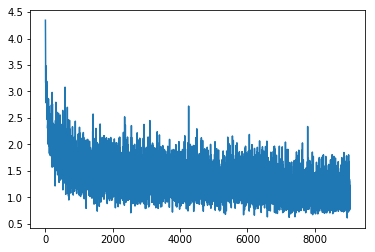

In [52]:
plt.plot(losses)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: